In [1]:
import sys
%reload_ext autoreload
%autoreload 2

from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from mcfacts.inputs.settings_manager import SettingsManager, AGNDisk
from mcfacts.objects.actors import InitialObjectReclassification, InnerDiskFilter, FlipRetroProFilter
from mcfacts.objects.agn_object_array import *
from mcfacts.objects.galaxy import Galaxy
from mcfacts.objects.populators import SingleBlackHolePopulator
from mcfacts.objects.snapshot import TxtSnapshotHandler
from mcfacts.objects.timeline import SimulationTimeline
from mcfacts.modules.accretion import ProgradeBlackHoleAccretion, BinaryBlackHoleAccretion
from mcfacts.modules.damping import ProgradeBlackHoleDamping, BinaryBlackHoleDamping
from mcfacts.modules.disk_capture import RecaptureRetrogradeBlackHoles, RecaptureBinaryBlackHoles, CaptureProgradeBlackHoles
from mcfacts.modules.dynamics import SingleBlackHoleDynamics, BinaryBlackHoleDynamics
from mcfacts.modules.gas_hardening import BinaryBlackHoleGasHardening
from mcfacts.modules.formation import BinaryBlackHoleFormation
from mcfacts.modules.merge import ProcessesBinaryBlackHoleMergers
from mcfacts.modules.migration import ProgradeBlackHoleMigration
from mcfacts.objects.actors.reality_checks import SingleBlackHoleRealityCheck, BinaryBlackHoleRealityCheck
from mcfacts.modules.gw import BinaryBlackHoleEvolveGW

# Seed should be 128 bits long to ensure random has enough entropy (as per NumPy documentation)
#
# import secrets
# secret.randombits(128)

settings = SettingsManager({
    "verbose": False,
    "override_files": True,
    "save_state": True,
    "save_each_timestep": True
})

population_cabinet = FilingCabinet()

agn_disk = AGNDisk(settings)
snapshot_handler = TxtSnapshotHandler(settings)

n_galaxy = 100

pbar = tqdm(total=n_galaxy, position=0, leave=True)

for galaxy_id in range(n_galaxy):
    pbar.set_description(f"Running Galaxy {galaxy_id}")
    pbar.update(1)

    galaxy_seed = 223849053863469657747974663531730220530 - galaxy_id

    # Create instance of galaxy
    galaxy = Galaxy(seed=galaxy_seed, runs_folder="./runs", galaxy_id=galaxy_id, settings=settings)

    # Create instance of populators
    single_bh_populator = SingleBlackHolePopulator()
    #single_star_populator = SingleStarPopulator("single_stars")
    galaxy.populate([single_bh_populator], agn_disk)

    # Create timeline to classify objects created during population
    pre_timeline = SimulationTimeline("Reclassification", timesteps=1, timestep_length=0)
    pre_timeline.add_timeline_actor(InitialObjectReclassification())
    pre_timeline.add_timeline_actor(SingleBlackHoleRealityCheck())
    galaxy.run(pre_timeline, agn_disk)

    #settings=SettingsManager({**settings.settings_overrides, "verbose": True})
    # Create timeline to run main simulation
    dynamics_timeline = SimulationTimeline("Dynamics", timesteps=60, timestep_length=galaxy.settings.timestep_duration_yr)

    singleton_dynamics = [
        ProgradeBlackHoleMigration(),
        ProgradeBlackHoleAccretion(),
        ProgradeBlackHoleDamping(),
        RecaptureRetrogradeBlackHoles(),
        SingleBlackHoleDynamics(),
        CaptureProgradeBlackHoles(),
        SingleBlackHoleRealityCheck()
    ]

    binary_dynamics = [
        BinaryBlackHoleDamping(),
        BinaryBlackHoleDynamics(reality_merge_checks=True),
        BinaryBlackHoleAccretion(reality_merge_checks=True),
        BinaryBlackHoleGasHardening(reality_merge_checks=True),
        RecaptureBinaryBlackHoles(),
        BinaryBlackHoleEvolveGW(),
        ProcessesBinaryBlackHoleMergers(),
        BinaryBlackHoleRealityCheck()
    ]

    dynamics_timeline.add_timeline_actors(singleton_dynamics)
    dynamics_timeline.add_timeline_actors(binary_dynamics)

    dynamics_timeline.add_timeline_actor(BinaryBlackHoleFormation())

    # Misc Disk Checks
    dynamics_timeline.add_timeline_actor(InnerDiskFilter())
    dynamics_timeline.add_timeline_actor(FlipRetroProFilter())

    galaxy.run(dynamics_timeline, agn_disk)

    # Create timeline to cleanup the final bits and bobs at the end of a
    # cleanup_timeline = SimulationTimeline("Cleanup", timesteps=1, timestep_length=0)
    # cleanup_timeline.add_timeline_actor(BreakupBinaryBlackHoles())
    # galaxy.run(cleanup_timeline, agn_disk)

    if "blackholes_merged" in galaxy.filing_cabinet:
        population_cabinet.create_or_append_array("blackholes_merged", galaxy.filing_cabinet.get_array("blackholes_merged"))

pbar.close()

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+08 MSun
Mdot = 2.596689e+00 MSun/yr
le = 1.0
Rs = 9.570121e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=3502 (R=9.06e+02 Rs)
Beginning star formation at index 3502
Mdisk = 422372550.2716628 Msun
Mdisk/Mbh = 4.223725502716627


  0%|          | 0/100 [00:00<?, ?it/s]

In [2]:
snapshot_handler = TxtSnapshotHandler(settings)

snapshot_handler.save_cabinet("./runs", "population", population_cabinet)

In [3]:
import matplotlib.ticker as mticker
import numpy as np
from scripts.population_plots import linefunc
from scipy.optimize import curve_fit

from mcfacts.vis import styles
from mcfacts.vis import plotting

figsize = "apj_col"

def make_gen_masks(gen_obj1, gen_obj2):
    """Create masks for retrieving different sets of a merged or binary population based on generation.
    """
    # Column of generation data

    # Masks for hierarchical generations
    # g1 : all 1g-1g objects
    # g2 : 2g-1g and 2g-2g objects
    # g3 : >=3g-Ng (first object at least 3rd gen; second object any gen)
    # Pipe operator (|) = logical OR. (&)= logical AND.
    g1_mask = (gen_obj1 == 1) & (gen_obj2 == 1)
    g2_mask = ((gen_obj1 == 2) | (gen_obj2 == 2)) & ((gen_obj1 <= 2) & (gen_obj2 <= 2))
    gX_mask = (gen_obj1 >= 3) | (gen_obj2 >= 3)

    return g1_mask, g2_mask, gX_mask

mergers = population_cabinet.get_array("blackholes_merged")
mass_final = mergers.mass_final

merger_g1_mask, merger_g2_mask, merger_gX_mask = make_gen_masks(mergers.gen_1, mergers.gen_2)

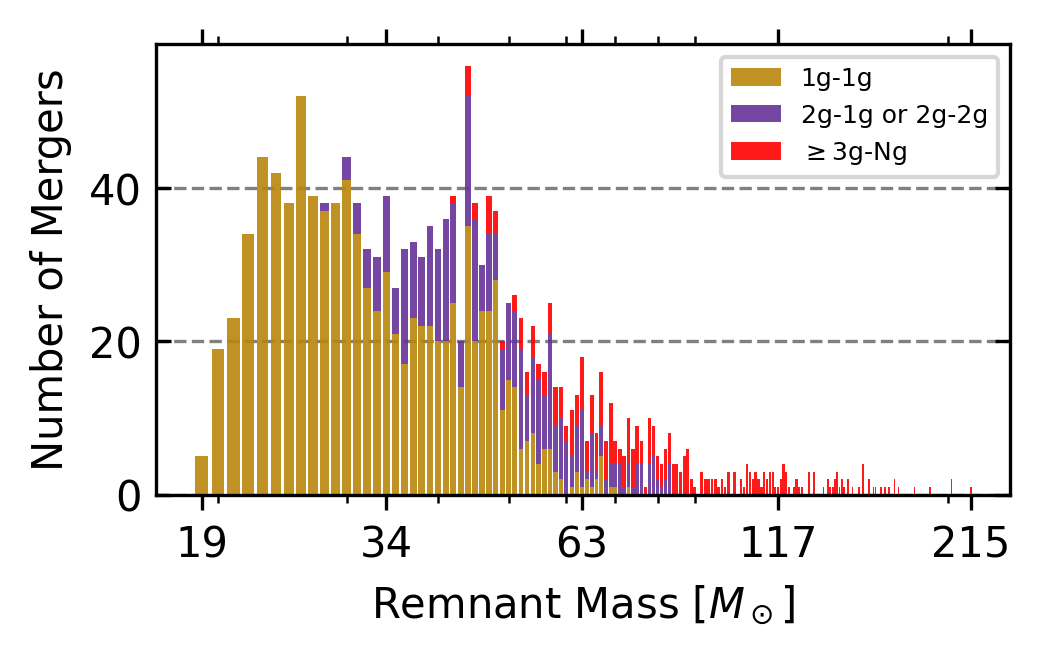

In [4]:
fig = plt.figure(figsize=plotting.set_size(figsize))
counts, bins = np.histogram(mass_final)
bins = np.arange(int(mass_final.min()), int(mass_final.max()) + 2, 1)

hist_data = [mass_final[merger_g1_mask], mass_final[merger_g2_mask], mass_final[merger_gX_mask]]
hist_label = ['1g-1g', '2g-1g or 2g-2g', r'$\geq$3g-Ng']
hist_color = [styles.color_gen1, styles.color_gen2, styles.color_genX]

plt.hist(hist_data, bins=bins, align='left', color=hist_color, alpha=0.9, rwidth=0.8, label=hist_label, stacked=True)

plt.ylabel('Number of Mergers')
plt.xlabel(r'Remnant Mass [$M_\odot$]')
plt.xscale('log')
svf_ax = plt.gca()
svf_ax.set_axisbelow(True)
svf_ax.tick_params(axis='x', direction='out', which='both')
svf_ax.yaxis.grid(True, color='gray', ls='dashed')

plt.xticks(np.geomspace(int(mass_final.min()), int(mass_final.max()), 5).astype(int))

svf_ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}'))
svf_ax.xaxis.set_minor_formatter(mticker.NullFormatter())

if figsize == 'apj_col':
    plt.legend(fontsize=6)
elif figsize == 'apj_page':
    plt.legend()

#plt.savefig(opts.plots_directory + r"/merger_remnant_mass.png", format='png')

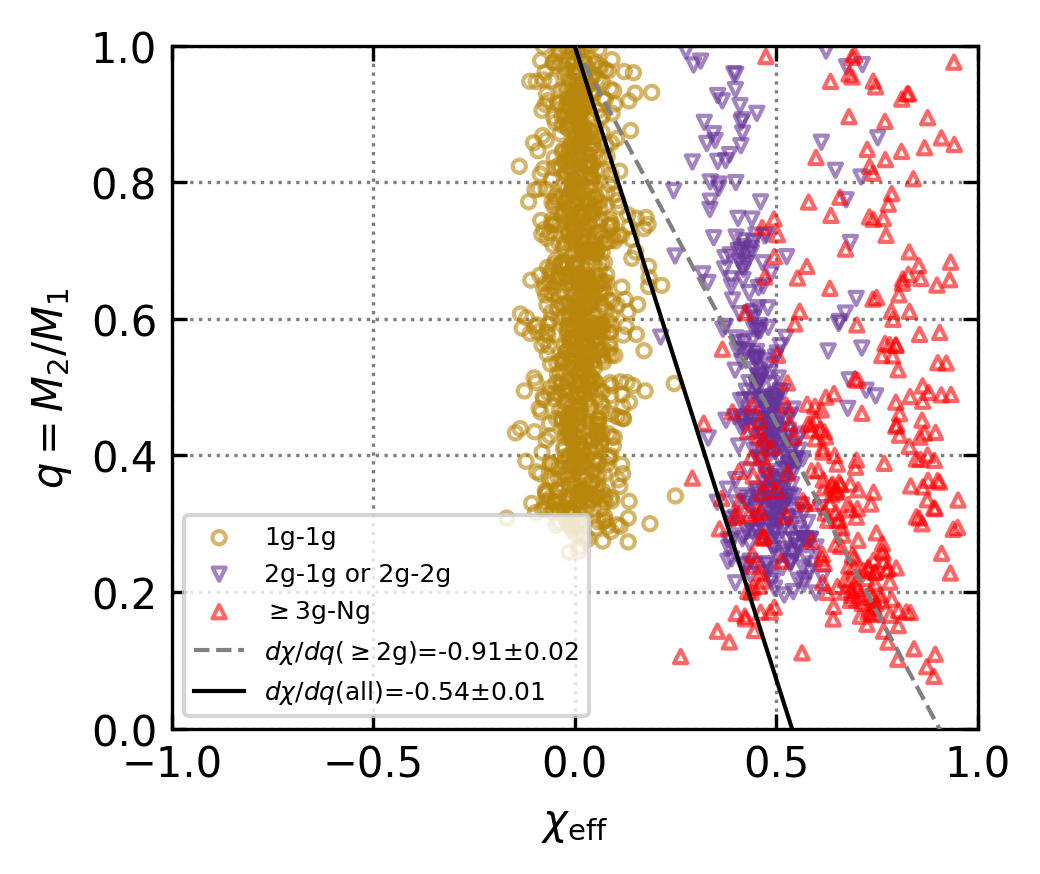

In [5]:
# retrieve component masses and mass ratio
m1 = np.zeros(len(mergers))
m2 = np.zeros(len(mergers))
mass_ratio = np.zeros(len(mergers))

for i in range(len(mergers)):
    if mergers.mass_1[i] < mergers.mass_2[i]:
        m1[i] = mergers.mass_1[i]
        m2[i] = mergers.mass_2[i]
    else:
        m1[i] = mergers.mass_2[i]
        m2[i] = mergers.mass_1[i]

    mass_ratio[i] = m1[i] / m2[i]

# (q,X_eff) Figure details here:
# Want to highlight higher generation mergers on this plot
chi_eff = mergers.chi_eff

# Get 1g-1g population
gen1_chi_eff = chi_eff[merger_g1_mask]
gen1_mass_ratio = mass_ratio[merger_g1_mask]
# 2g-1g and 2g-2g population
gen2_chi_eff = chi_eff[merger_g2_mask]
gen_mass_ratio = mass_ratio[merger_g2_mask]
# >=3g-Ng population (i.e., N=1,2,3,4,...)
genX_chi_eff = chi_eff[merger_gX_mask]
genX_mass_ratio = mass_ratio[merger_gX_mask]
# all 2+g mergers; H = hierarchical
genH_chi_eff = chi_eff[(merger_g2_mask + merger_gX_mask)]
genH_mass_ratio = mass_ratio[(merger_g2_mask + merger_gX_mask)]

# points for plotting line fit
x = np.linspace(-1, 1, num=2)

# fit the hierarchical mergers (any binaries with 2+g) to a line passing through 0,1
# popt contains the model parameters, pcov the covariances
# poptHigh, pcovHigh = curve_fit(linefunc, high_gen_mass_ratio, high_gen_chi_eff)

# plot the 1g-1g population
fig = plt.figure(figsize=(plotting.set_size(figsize)[0], 2.8))
ax2 = fig.add_subplot(111)
# 1g-1g mergers
ax2.scatter(gen1_chi_eff, gen1_mass_ratio,
            s=styles.markersize_gen1,
            marker=styles.marker_gen1,
            edgecolor=styles.color_gen1,
            facecolor='none',
            alpha=styles.markeralpha_gen1,
            label='1g-1g'
            )

# plot the 2g+ mergers
ax2.scatter(gen2_chi_eff, gen_mass_ratio,
            s=styles.markersize_gen2,
            marker=styles.marker_gen2,
            edgecolor=styles.color_gen2,
            facecolor='none',
            alpha=styles.markeralpha_gen2,
            label='2g-1g or 2g-2g'
            )

# plot the 3g+ mergers
ax2.scatter(genX_chi_eff, genX_mass_ratio,
            s=styles.markersize_genX,
            marker=styles.marker_genX,
            edgecolor=styles.color_genX,
            facecolor='none',
            alpha=styles.markeralpha_genX,
            label=r'$\geq$3g-Ng'
            )

if len(genH_chi_eff) > 0:
    poptHier, pcovHier = curve_fit(linefunc, genH_mass_ratio, genH_chi_eff)
    errHier = np.sqrt(np.diag(pcovHier))[0]
    # plot the line fitting the hierarchical mergers
    ax2.plot(linefunc(x, *poptHier), x,
             ls='dashed',
             lw=1,
             color='gray',
             zorder=3,
             label=r'$d\chi/dq(\geq$2g)=' +
                   f'{poptHier[0]:.2f}' +
                   r'$\pm$' + f'{errHier:.2f}'
             )
    #         #  alpha=linealpha,

if len(chi_eff) > 0:
    poptAll, pcovAll = curve_fit(linefunc, mass_ratio, chi_eff)
    errAll = np.sqrt(np.diag(pcovAll))[0]
    ax2.plot(linefunc(x, *poptAll), x,
             ls='solid',
             lw=1,
             color='black',
             zorder=3,
             label=r'$d\chi/dq$(all)=' +
                   f'{poptAll[0]:.2f}' +
                   r'$\pm$' + f'{errAll:.2f}'
             )

ax2.set(
    ylabel=r'$q = M_2 / M_1$',  # ($M_1 > M_2$)')
    xlabel=r'$\chi_{\rm eff}$',
    ylim=(0, 1),
    xlim=(-1, 1),
    axisbelow=True
)

if figsize == 'apj_col':
    ax2.legend(loc='lower left', fontsize=6)
elif figsize == 'apj_page':
    ax2.legend(loc='lower left')

ax2.grid('on', color='gray', ls='dotted')

In [ ]:
import secrets

# from mcfacts.mcfacts_random_state import reset_random
# 
# reset_random(223849053863469657747974663531730220530)

secrets.randbits(128)

# disk_bh_pro_orbs_ecc = np.asarray([0.01, 0.2, 0.01, 0.02, 2, 0.2])
# 
# 
# indices_bh_can_form_bins = np.asarray(disk_bh_pro_orbs_ecc <= 0.01).nonzero()[0]
# 
# print(indices_bh_can_form_bins)

In [ ]:
print(galaxy.timeline_history[0].get_timeline_actor(0).settings.settings_finals)

In [ ]:
for x, y in galaxy.filing_cabinet.agn_objects.items():
    print (f"{x}, {len(y.unique_id)}")

In [ ]:
galaxy.filing_cabinet.get_array(galaxy.settings.bh_array_name).get_super_dict()

In [ ]:
len(galaxy.filing_cabinet.get_array(galaxy.settings.bh_inner_disk_array_name))

In [ ]:
super_list = galaxy.filing_cabinet.get_array(galaxy.settings.bh_inner_disk_array_name).get_super_dict()

for key, value in super_list.items():
    print(f"{key}: {value}")